# 프로젝트 - Movielens 영화 SBR

Movielens 1M Dataset을 기반으로, Session based Recommendation 시스템을 제작해 보겠습니다.

```bash
$ wget http://files.grouplens.org/datasets/movielens/ml-1m.zip
```

In [1]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose-data/ml-1m') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data = data.sort_values(['UserId'], inplace=False)  # data를 id와 시간 순서로 정렬해줍니다. # inplace = False면 자체를 다시 저장
data = data.reset_index(drop=True)
data

,UserId,ItemId,Rating,Time
0,1,1193,5,978300760
1,1,745,3,978824268
2,1,2294,4,978824291
3,1,3186,4,978300019
4,1,1566,4,978824330
...,...,...,...,...
1000204,6040,1594,3,964828599
1000205,6040,1587,1,956716374
1000206,6040,3182,5,984195682
1000207,6040,300,2,956704716


- 여기서 이전 실습내역과 가장 크게 다른 부분은 바로 SessionID 대신 UserID 항목이 들어갔다는 점입니다. 이 데이터셋은 명확한 1회 세션의 SessionID를 포함하지 않고 있습니다. 그래서 이번에는 UserID가 SessionID 역할을 해야 합니다.

- Rating 정보가 포함되어 있습니다. 이전 실습내역에서는 이런 항목이 포함되어 있지 않았으므로, 무시하고 제외할 수 있습니다. 하지만, 직전에 봤던 영화가 맘에 들었는지 여부가 비슷한 영화를 더 고르게 하는 것과 상관이 있을 수도 있습니다. 아울러, Rating이 낮은 데이터를 어떻게 처리할지도 고민해야 합니다.

- Time 항목에는 UTC time 가 포함되어, 1970년 1월 1일부터 경과된 초단위 시간이 기재되어 있습니다.

위와 같은 정보를 바탕으로 오늘의 실습과정과 유사한 프로젝트 과정을 진행해 보겠습니다.

## Step 1. 데이터의 전처리

위와 같이 간단히 구성해 본 데이터셋을 꼼꼼이 살펴보면서 항목별 기본분석, session length, session time, cleaning 등의 작업을 진행합니다.
특히, 이 데이터셋에서는 Session이 아닌 UserID 단위로 데이터가 생성되어 있으므로, 이를 Session 단위로 어떻게 해석할지에 주의합니다.

같은 UserId에서 Time 별로 다시 줄을 세워보도록하겠습니다.

In [3]:
data['UserId'].nunique()

6040

In [4]:
userid_length = data.groupby('UserId').size()
userid_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [5]:
userid_length[1]

53

In [6]:
len(userid_length)

6040

In [7]:
temp_df = data[0:0+userid_length[1]]
temp_df = temp_df.sort_values(['Time'], inplace= False)
temp_df = temp_df.reset_index(drop=True)
temp_df

,UserId,ItemId,Rating,Time
0,1,3186,4,978300019
1,1,1270,5,978300055
2,1,1022,5,978300055
3,1,1721,4,978300055
4,1,2340,3,978300103
5,1,1836,5,978300172
6,1,3408,4,978300275
7,1,2804,5,978300719
8,1,1207,4,978300719
9,1,1193,5,978300760


In [8]:
ii = 0
new_df = data[0:1]
for i in range(len(userid_length)):
    temp_df = data[ii:ii+userid_length[i+1]]
    temp_df = temp_df.sort_values(['Time'], inplace= False)
    ii += userid_length[i+1]
    new_df = new_df.append(temp_df)
    new_df = new_df.reset_index(drop=True)

In [9]:
new_df = new_df[1:1000210]

In [10]:
new_df

,UserId,ItemId,Rating,Time
1,1,3186,4,978300019
2,1,1270,5,978300055
3,1,1022,5,978300055
4,1,1721,4,978300055
5,1,2340,3,978300103
...,...,...,...,...
1000205,6040,2917,4,997454429
1000206,6040,1784,3,997454464
1000207,6040,1921,4,997454464
1000208,6040,161,3,997454486


In [11]:
new_df['Time_new'] = pd.to_datetime(new_df['Time'], unit='s')

In [12]:
new_df

,UserId,ItemId,Rating,Time,Time_new
1,1,3186,4,978300019,2000-12-31 22:00:19
2,1,1270,5,978300055,2000-12-31 22:00:55
3,1,1022,5,978300055,2000-12-31 22:00:55
4,1,1721,4,978300055,2000-12-31 22:00:55
5,1,2340,3,978300103,2000-12-31 22:01:43
...,...,...,...,...,...
1000205,6040,2917,4,997454429,2001-08-10 14:40:29
1000206,6040,1784,3,997454464,2001-08-10 14:41:04
1000207,6040,1921,4,997454464,2001-08-10 14:41:04
1000208,6040,161,3,997454486,2001-08-10 14:41:26


rating이 3미만인 영화들은 지워주도록 하겠습니다.

In [13]:
new_df = new_df[new_df['Rating']>=3]
new_df = new_df.reset_index(drop=True)

In [14]:
new_df

,UserId,ItemId,Rating,Time,Time_new
0,1,3186,4,978300019,2000-12-31 22:00:19
1,1,1270,5,978300055,2000-12-31 22:00:55
2,1,1022,5,978300055,2000-12-31 22:00:55
3,1,1721,4,978300055,2000-12-31 22:00:55
4,1,2340,3,978300103,2000-12-31 22:01:43
...,...,...,...,...,...
836473,6040,2917,4,997454429,2001-08-10 14:40:29
836474,6040,1784,3,997454464,2001-08-10 14:41:04
836475,6040,1921,4,997454464,2001-08-10 14:41:04
836476,6040,161,3,997454486,2001-08-10 14:41:26


In [15]:
new_df['SessionId'] = 0

In [16]:
new_df

,UserId,ItemId,Rating,Time,Time_new,SessionId
0,1,3186,4,978300019,2000-12-31 22:00:19,0
1,1,1270,5,978300055,2000-12-31 22:00:55,0
2,1,1022,5,978300055,2000-12-31 22:00:55,0
3,1,1721,4,978300055,2000-12-31 22:00:55,0
4,1,2340,3,978300103,2000-12-31 22:01:43,0
...,...,...,...,...,...,...
836473,6040,2917,4,997454429,2001-08-10 14:40:29,0
836474,6040,1784,3,997454464,2001-08-10 14:41:04,0
836475,6040,1921,4,997454464,2001-08-10 14:41:04,0
836476,6040,161,3,997454486,2001-08-10 14:41:26,0


In [17]:
len(new_df)

836478

In [18]:
for i in range(5):
    print(i)

0
1
2
3
4


In [19]:
sessionid = 1

new_df['SessionId'][0]=1

In [20]:
new_df

,UserId,ItemId,Rating,Time,Time_new,SessionId
0,1,3186,4,978300019,2000-12-31 22:00:19,1
1,1,1270,5,978300055,2000-12-31 22:00:55,0
2,1,1022,5,978300055,2000-12-31 22:00:55,0
3,1,1721,4,978300055,2000-12-31 22:00:55,0
4,1,2340,3,978300103,2000-12-31 22:01:43,0
...,...,...,...,...,...,...
836473,6040,2917,4,997454429,2001-08-10 14:40:29,0
836474,6040,1784,3,997454464,2001-08-10 14:41:04,0
836475,6040,1921,4,997454464,2001-08-10 14:41:04,0
836476,6040,161,3,997454486,2001-08-10 14:41:26,0


In [21]:
for i in range(len(new_df)-1):
    if new_df['UserId'][i] == new_df['UserId'][i+1]:
        
        if (new_df['Time'][i+1]-new_df['Time'][i]) <= 1800:
            new_df['SessionId'][i+1] = sessionid
        
        else:
            
            sessionid += 1
            new_df['SessionId'][i+1] = sessionid
    else: 
        
        sessionid += 1
        new_df['SessionId'][i+1] = sessionid

In [22]:
new_df

,UserId,ItemId,Rating,Time,Time_new,SessionId
0,1,3186,4,978300019,2000-12-31 22:00:19,1
1,1,1270,5,978300055,2000-12-31 22:00:55,1
2,1,1022,5,978300055,2000-12-31 22:00:55,1
3,1,1721,4,978300055,2000-12-31 22:00:55,1
4,1,2340,3,978300103,2000-12-31 22:01:43,1
...,...,...,...,...,...,...
836473,6040,2917,4,997454429,2001-08-10 14:40:29,24142
836474,6040,1784,3,997454464,2001-08-10 14:41:04,24142
836475,6040,1921,4,997454464,2001-08-10 14:41:04,24142
836476,6040,161,3,997454486,2001-08-10 14:41:26,24142


In [ ]:
sessionid = 0

In [ ]:
for i in range()
new_df['SessionId'][i]

In [22]:
data['Time'][0]

978300760

In [ ]:
for UserId in data['UserId']:
    if data['UserId'] == UserId:
        data.sort_values(['UserId', 'Time'], inplace=False)

In [8]:
temp_SessionId = 1
i = 0
for UserId in data['UserId']:
    if data['UserId'] == UserId:
        if data['Time'][i]
    

978302109
978302109
978302109
978302109
978302109
978302109
978302109
978302109
978302109
978302109
978302109
978302109
978302109
978302109
978302109
978302109
978302109
978302109
978302109
978302109
978302109
978302109
978302109
978302109
978302109
978302109
978302109
978302109
978302109
978302109
978302109
978302109
978302109
978302109
978302109
978302109
978302109
978302109
978302109
978302109
978302109
978302109
978302109
978302109
978302109
978302109
978302109
978302109
978302109
978302109
978302109
978302109
978302109
978301968
978301968
978301968
978301968
978301968
978301968
978301968
978301968
978301968
978301968
978301968
978301968
978301968
978301968
978301968
978301968
978301968
978301968
978301968
978301968
978301968
978301968
978301968
978301968
978301968
978301968
978301968
978301968
978301968
978301968
978301968
978301968
978301968
978301968
978301968
978301968
978301968
978301968
978301968
978301968
978301968
978301968
978301968
978301968
978301968
978301968
978301968


978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753
978301753


KeyError: 67

In [ ]:
for UserId in data['UserId']:
    

In [20]:
print(data['UserId'].nunique())
print(data['ItemId'].nunique())

9
7


In [6]:
user_length = data.groupby('UserId').size()
user_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [7]:
user_length.median(), user_length.mean()

(96.0, 165.5975165562914)

In [8]:
user_length.min(), user_length.max()

(20, 2314)

In [9]:
user_length.quantile(0.999)

1343.181000000005

In [10]:
long_session = user_length[user_length==2314].index[0]
data[data['UserId']==long_session]

,UserId,ItemId,Rating,Time,Time_new
696969,4169,1268,5,965333392,2000-08-03 20:09:52
697168,4169,2617,4,965333392,2000-08-03 20:09:52
697185,4169,2628,4,965333392,2000-08-03 20:09:52
697219,4169,2653,4,965333392,2000-08-03 20:09:52
697275,4169,423,3,965333392,2000-08-03 20:09:52
...,...,...,...,...,...
697882,4169,3754,2,1024174347,2002-06-15 20:52:27
695702,4169,1413,3,1024175031,2002-06-15 21:03:51
697358,4169,494,4,1024175760,2002-06-15 21:16:00
695945,4169,1804,2,1024175783,2002-06-15 21:16:23


In [13]:
length_count = user_length.groupby(user_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

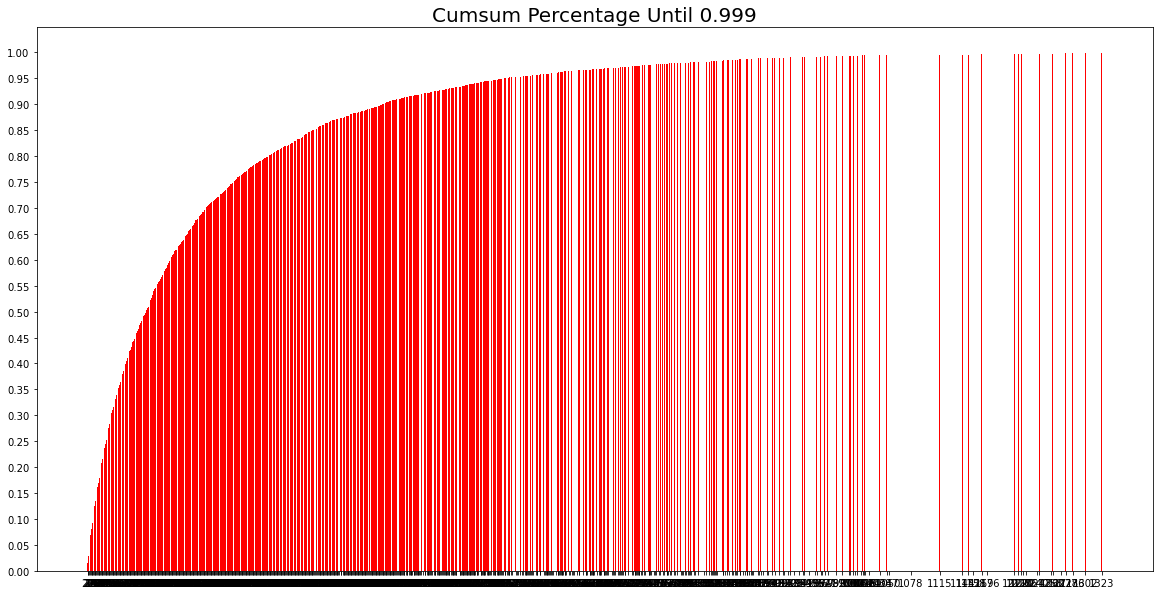

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

In [15]:
oldest, latest = data['Time_new'].min(), data['Time_new'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


In [17]:
month_ago = latest - dt.timedelta(30)     # 최종 날짜로부터 30일 이전 날짜를 구한다.  
data = data[data['Time_new'] > month_ago]   # 방금 구한 날짜 이후의 데이터만 모은다. 
data

,UserId,ItemId,Rating,Time,Time_new
28225,195,2808,3,1044220118,2003-02-02 21:08:38
27759,195,1254,4,1044552222,2003-02-06 17:23:42
27921,195,1456,2,1044662852,2003-02-08 00:07:32
28443,195,468,3,1044985356,2003-02-11 17:42:36
28255,195,2748,1,1044987808,2003-02-11 18:23:28
...,...,...,...,...,...
984731,5950,3948,4,1046369637,2003-02-27 18:13:57
984682,5950,3578,4,1046369670,2003-02-27 18:14:30
984475,5950,3793,3,1046369710,2003-02-27 18:15:10
984660,5950,3555,2,1046369737,2003-02-27 18:15:37


In [18]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [19]:
data = cleanse_recursive(data, shortest=2, least_click=5)
data

,UserId,ItemId,Rating,Time,Time_new
58836,398,2028,4,1044565425,2003-02-06 21:03:45
58784,398,2762,5,1044565753,2003-02-06 21:09:13
58730,398,2628,3,1044566296,2003-02-06 21:18:16
58837,398,3697,2,1044566464,2003-02-06 21:21:04
58645,398,1196,4,1044567541,2003-02-06 21:39:01
62105,419,2424,4,1044900624,2003-02-10 18:10:24
62170,419,2028,5,1044900801,2003-02-10 18:13:21
62078,419,1196,5,1044900920,2003-02-10 18:15:20
62145,419,2762,5,1044901328,2003-02-10 18:22:08
62071,419,3793,4,1044901354,2003-02-10 18:22:34


## Step 2. 미니 배치의 구성

실습코드 내역을 참고하여 데이터셋과 미니 배치를 구성해 봅시다. Session-Parallel Mini-Batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있도록 구성합니다.
단, 위 Step 1에서 Session 단위를 어떻게 정의했느냐에 따라서 Session-Parallel Mini-Batch이 굳이 필요하지 않을 수도 있습니다.

## Step 3. 모델 구성

이 부분도 실습코드 내역을 참고하여 다양하게 모델 구조를 시도해볼 수 있습니다.

## Step 4. 모델 학습

다양한 하이퍼파라미터를 변경해 보며 검증해 보도록 합니다. 실습코드에 언급되었던 Recall, MRR 등의 개념들도 함께 관리될 수 있도록 합니다.

## Step 5. 모델 테스트

미리 구성한 테스트셋을 바탕으로 Recall, MRR 을 확인해 봅니다.